# Set up details of systems being studied

In [ ]:
# Settings for Methyl Anthranilate, running on SCRTP nanosim nodes, HPC Midlands+ Athena, and ARCHER

from esteem import drivers
from esteem import parallel
from copy import deepcopy

# Get default arguments for each script, then edit below
from esteem.tasks.solutes import SolutesTask
from esteem.tasks.solvate import SolvateTask
from esteem.tasks.clusters import ClustersTask
from esteem.tasks.spectra import SpectraTask
from esteem.tasks.ml_training import MLTrainingTask
from esteem.tasks.qmd_trajectories import QMDTrajTask
from esteem.tasks.ml_trajectories import MLTrajTask
from esteem.tasks.ml_testing import MLTestingTask

# Set up Wrappers to run underlying packages
from esteem.wrappers import onetep, nwchem, orca, amber, physnet, lammps

solutes_task = SolutesTask()
solvate_task = SolvateTask()
clusters_task = ClustersTask()
spectra_task = SpectraTask()
qmd_task = QMDTrajTask()
train_task = MLTrainingTask()
mltraj_task = MLTrajTask()
test_task = MLTestingTask()

# List of all solvents to use
all_solvents = {"etoh": "ethanol",
               "acet": "acetonitrile",
               "cycl": "cyclohexane"
               }

# List of all solutes to use
all_solutes = {"pma": "pmab (me-4-ab)",
               "mma": "mmab (me-3-ab)",
               "oma": "omab (me-2-ab)",
               "etoh": "ethanol",
               "acet": "acetonitrile",
               "cycl": "cyclohexane"
               }

train_calcs = ['ABEF','ABEFIJMN','ABEFGHIJMN','ABEFGHIJMNPQ']

targets = {0: "gs",1: "es1", 2: "es2"}

# Settings for Solutes script
solutes_task.wrapper = orca.ORCAWrapper()
solutes_task.wrapper.setup(nprocs=16,maxcore=3000)
solutes_task.script_settings = parallel.sulis_1node_100 #parallel.get_default_script_settings(solutes_task.wrapper)
solutes_task.basis = '6-311++G**'
solutes_task.disp = True
solutes_task.nroots = 0
solutes_task.rotate      = False
solutes_task.vibrations  = True
solutes_task.calc_params = None
all_solutes_tasks = {}
for func in 'PBE', 'PBE0':
    for target in targets:
        solutes_task.func  = func
        solutes_task.target = target
        solutes_task.directory = f'{solutes_task.func}_{targets[target]}'
        all_solutes_tasks[solutes_task.directory] = deepcopy(solutes_task)

# Settings for Solvate script
solvate_task.wrapper = amber.AmberWrapper(nprocs=32)
solvate_task.script_settings = parallel.get_default_script_settings(solvate_task.wrapper)
solvate_task.temp        = 300 # Kelvin
solvate_task.boxsize     = 20  # Angstrom
solvate_task.md_geom_prefix = "PBE0/is_opt"
solvate_task.ewaldcut = 12.0 # Angstrom
solvate_task.nheat = 10000
solvate_task.ndens = 100000
solvate_task.nequil = 50000
solvate_task.nsteps = 2000
solvate_task.nsnaps = 2500
all_solvate_tasks = {}

MDtemps = [300,350,400]
for T in MDtemps:
    solvate_task.temp = T
    solvate_task.md_suffix = f'md{T}'
    all_solvate_tasks[solvate_task.md_suffix] = deepcopy(solvate_task)

# Settings for Clusters script
clusters_task.output = 'orca'
clusters_task.func     = 'PBE0'
clusters_task.basis    = '6-311++G**'
clusters_task.disp     = True
clusters_task.boxsize  = None
clusters_task.nroots   = 0 #2
clusters_task.calc_forces = True
clusters_task.md_suffix = 'solv'
all_clusters_tasks = {}

MDchar = ['R','S','T']
cluster_radii = {'A': 0.0, 'B': 2.5, 'C': 5.0, 'D': 7.5}
for i,MDtemp in enumerate(MDtemps):
    for cr in cluster_radii:
        r = cluster_radii[cr]
        clusters_task.wrapper = orca.ORCAWrapper()
        clusters_task.script_settings = parallel.get_default_script_settings(clusters_task.wrapper)
        nprocs = 16 if r==2.5 else 16
        clusters_task.wrapper.setup(nprocs=nprocs,maxcore=4000)
        clusters_task.script_settings['ntask'] = 1
        clusters_task.script_settings['ncpu'] = nprocs
        MDstr = MDchar[i]
        clusters_task.max_snapshots = 2000 if r==0.0 else 2000
        clusters_task.md_prefix = f'{{solu}}_{{solv}}_md{MDtemp}'
        clusters_task.exc_suffix = f'solv{MDstr}{r}'
        clusters_task.radius = r if r!=2.5 else 2.5; # CAN HACK HERE TO SET ACET_ACET_solvR2.5 to R3.0
        for w in ['A','B']:
            clusters_task.which_traj = w
            clusters_task.max_snapshots = 2000 if w == 'A' else 2500
            clusters_task.min_snapshots = 0 if w == 'A' else 2000
            all_clusters_tasks[clusters_task.exc_suffix+'_'+w] = deepcopy(clusters_task)

dft_wrapper = orca.ORCAWrapper()
dft_wrapper.setup(nprocs=32,maxcore=3000)
ml_wrapper = physnet.PhysNetWrapper()
ml_wrapper.update_atom_e = True
ml_wrapper.script_settings = parallel.get_default_script_settings(ml_wrapper)
for t in train_calcs:
    for target in targets:
        clusters_task.md_prefix = f'{{solu}}_{{solv}}_{targets[target]}_NN{t}_mldyn'
        clusters_task.md_suffix = [f'{targets[target]}_{i}_NN{t}_mldyn' for i in ['A','B','C','D','E']]
        clusters_task.radius = 2.5
        clusters_task.nroots = 1
        clusters_task.min_snapshots = 0
        clusters_task.max_snapshots = 100
        clusters_task.exc_suffix = f'{targets[target]}_NN{t}_mlclus'
        clusters_task.wrapper = dft_wrapper
        clusters_task.script_settings = parallel.get_default_script_settings(dft_wrapper)
        clusters_task.output = 'orca'
        clusters_task.which_traj = 'O'
        all_clusters_tasks[clusters_task.exc_suffix] = deepcopy(clusters_task)
        clusters_task.output = 'physnet'
        clusters_task.wrapper = ml_wrapper 
        clusters_task.script_settings = parallel.get_default_script_settings(ml_wrapper)
        clusters_task.calc_seed = 'all_etoh'
        clusters_task.calc_suffix = f'NN{t}'
        for cr in cluster_radii:
            clusters_task.which_traj = cr
            clusters_task.radius = cluster_radii[cr]
            clusters_task.target = 0
            clusters_task.nroots = 0
            all_clusters_tasks[clusters_task.exc_suffix+'_'+clusters_task.which_traj] = deepcopy(clusters_task)
            clusters_task.which_traj = chr(ord(clusters_task.which_traj)+len(cluster_radii))
            clusters_task.target = 1
            clusters_task.nroots = 1
            all_clusters_tasks[clusters_task.exc_suffix+'_'+clusters_task.which_traj] = deepcopy(clusters_task)

# Settings for Spectra script
spectra_task.broad = 0.05 # eV
spectra_task.inputformat   = 'orca'
spectra_task.wavelength    = (200,500,1) # nm
spectra_task.warp_origin_prefix = 'PBE/is_tddft'
spectra_task.warp_dest_prefix   = 'PBE0/is_tddft'
spectra_task.warp_inputformat   = 'nwchem'
spectra_task.warp_files         = 'tddft.nwo'
spectra_task.warp_scheme        = 'beta'

# Quantum Molecular Dynamics
from ase.units import fs,AUT
qmd_task.wrapper = orca.ORCAWrapper()
qmd_task.script_settings = parallel.get_default_script_settings(qmd_task.wrapper)
qmd_task.wrapper.setup(nprocs=1,maxcore=3200)
qmd_task.target       = 0
qmd_task.temp         = 800
qmd_task.nsnap        = 1
qmd_task.nequil       = 40
qmd_task.qmd_steps    = 10
qmd_task.qmd_timestep = 0.0*fs
qmd_task.ntraj        = 134
qmd_task.traj_suffix  = f'qmd{qmd_task.temp}'
qmd_task.constraints  = None
qmd_task.func         = 'PBE0'
qmd_task.basis        = '6-311++G**'
qmd_task.disp         = True
qmd_task.ref_mol_dir  = 'PBE0_gs'
qmd_task.solvent      = '{solu}'

# Training
train_task.wrapper = physnet.PhysNetWrapper()
train_task.script_settings = parallel.get_default_script_settings(train_task.wrapper)
train_task.traj_suffix = "orca"
train_task.cutoff = 10.0
train_task.restart = False
train_task.ntraj = 26

# Set wrapper-specific training parameters
if isinstance(train_task.wrapper,physnet.PhysNetWrapper):
    train_args =    {'force_weight': 52.91772105638412,
                    'charge_weight': 14.399645351950548,
                    'dipole_weight': 27.211386024367243,
                    'max_steps': 1000000,
                    'cutoff': train_task.cutoff}
    for a in train_args:
        train_task.wrapper.train_args[a] = train_args[a]

all_mltrain_tasks = {}
exc_suffix0 = "solvR0.0"
exc_suffix2 = "solvR2.5"
exc_suffix5 = "solvR5.0"
exc_suffixS = "solvS2.5"
exc_suffixT = "solvT2.5"
method = clusters_task.output
targets = {0: "gs",1: "es1",2: "es2"}
target0 = targets[0]
# All solvent/solute pairs link to same set of bare molecules in traj A (solvsp)
solvsp = "etoh"
#rand_seed = {'a': 5436,'b': 2341, 'c': 835, 'd': 324}
rand_seed = {'': 0}

for s in rand_seed:
    for target in targets:
        for t in train_calcs:
            train_task.which_trajs = t
            targstr = targets[target]
            train_task.traj_links = {}
            if 'EF' in t:
                train_task.traj_links["E"] = f"{{solv}}_{{solv}}_{exc_suffix0}/{{solv}}_{{solv}}_{target0}_A_{method}.traj"
                train_task.traj_links["F"] = f"{{solv}}_{{solv}}_{exc_suffix2}/{{solv}}_{{solv}}_{target0}_A_{method}.traj"
            if t=='ABEFIJMN' or t=='ABEFGHIJMN' or t=='ABEFGHIJMNPQ':
                sol0='mma'; sol1='oma'; sol2='pma'
                train_task.traj_links["E"] = f"{{solv}}_{{solv}}_{exc_suffix0}/{{solv}}_{{solv}}_{target0}_A_{method}.traj"
                train_task.traj_links["F"] = f"{{solv}}_{{solv}}_{exc_suffix2}/{{solv}}_{{solv}}_{target0}_A_{method}.traj"
                if 'GH' in t:
                   train_task.traj_links["G"] = f"{{solv}}_{{solv}}_{exc_suffixS}/{{solv}}_{{solv}}_{target0}_A_{method}.traj"
                   train_task.traj_links["H"] = f"{{solv}}_{{solv}}_{exc_suffixT}/{{solv}}_{{solv}}_{target0}_A_{method}.traj"
                if 'IJMN' in t:
                   train_task.traj_links["A"] = f"{sol0}_{solvsp}_{exc_suffix0}/{sol0}_{solvsp}_{targstr}_A_{method}.traj"
                   train_task.traj_links["B"] = f"{sol0}_{{solv}}_{exc_suffix2}/{sol0}_{{solv}}_{targstr}_A_{method}.traj"
                   train_task.traj_links["I"] = f"{sol1}_{solvsp}_{exc_suffix0}/{sol1}_{solvsp}_{targstr}_A_{method}.traj"
                   train_task.traj_links["J"] = f"{sol1}_{{solv}}_{exc_suffix2}/{sol1}_{{solv}}_{targstr}_A_{method}.traj"
                   train_task.traj_links["M"] = f"{sol2}_{solvsp}_{exc_suffix0}/{sol2}_{solvsp}_{targstr}_A_{method}.traj"
                   train_task.traj_links["N"] = f"{sol2}_{{solv}}_{exc_suffix2}/{sol2}_{{solv}}_{targstr}_A_{method}.traj"
                else:
                   train_task.traj_links["A"] = f"{{solu}}_{solvsp}_{exc_suffix0}/{{solu}}_{solvsp}_{targstr}_A_{method}.traj"
                   train_task.traj_links["B"] = f"{{solu}}_{{solv}}_{exc_suffix2}/{{solu}}_{{solv}}_{targstr}_A_{method}.traj"
                if 'Q' in t:
                    train_task.traj_links["Q"] = f"{{solv}}_extend/{{solv}}_extend_{target0}_A_{method}.traj"
                if 'P' in t:
                    train_task.traj_links["P"] = f"{{solv}}_extend/{{solv}}_extend_{target0}_A_{method}.traj"
                    #train_task.traj_links["P"] = f"all_{{solv}}_atoms_{method}.traj"

            train_task.target = target
            train_task.calc_suffix = "NN"+t+s
            train_task.calc_prefix = ""
            #train_task.wrapper.train_args['seed'] = rand_seed[s]
            all_mltrain_tasks[targets[target]+"_NN"+t+s] = deepcopy(train_task)
        
# ML Molecular Dynamics
mltraj_task.wrapper = physnet.PhysNetWrapper(lr_cut=10.0)
mltraj_task.script_settings = parallel.get_default_script_settings(mltraj_task.wrapper)
mltraj_task.temp        = 300 # Kelvin
mltraj_task.md_timestep = {'MD': 0.5*fs, 'EQ': 0.5*fs}
mltraj_task.md_friction = {'MD': 0.002, 'EQ': 0.02}
mltraj_task.md_steps    = 1000
mltraj_task.ntraj       = 100
mltraj_task.calc_prefix = ""
mltraj_task.which_trajs = 'ABCDEFGHIJ'
mltraj_task.nsnap       = 20
mltraj_task.nequil      = 5
mltraj_task.constraints = None
mltraj_task.store_full_traj = True

all_mltraj_tasks = {}
for target in targets:
    for t in train_calcs:
        mltraj_task.calc_suffix = "NN"+t
        targstr = targets[target]
        mltraj_task.calc_seed = f"{{solu}}_{{solv}}"
        if t=="ABEFIJMN" or t=="ABEFGHIJMN" or t=="ABEFGHIJMNPQ":
            mltraj_task.calc_seed = f"all_{{solv}}"
        if target == 0:
            mltraj_task.md_init_traj_link = f"{{solu}}_{{solv}}_{exc_suffix2}/{{solu}}_{{solv}}_solv.traj"
        else:
            mltraj_task.md_init_traj_link = [f"{{solu}}_{{solv}}_gs_NN{t}_mldyn/{{solu}}_{{solv}}_gs_{s}_NN{t}_mldyn.traj" for s in ['A','B','C','D','E']]
        mltraj_task.target = target
        mltraj_task.traj_suffix = mltraj_task.calc_suffix + '_mldyn'
        all_mltraj_tasks[targstr+'_NN'+t] = deepcopy(mltraj_task)

# Testing
#cluster_test_trajs = {'5A_{solu}_clusters': 'C'}
cluster_test_trajs = {'2.5A_{solu}_clusters': 'B',
                      '2.5A_{solv}_clusters': 'F',
                      '{solu}_mols': 'A',
                      '{solv}_mols': 'E'}
cluster_test_trajs_all = {
                          f'{{solv}}_extend': 'Q',
                          f'2.5A_{sol0}_clusters': 'B',
                          f'2.5A_{{solv}}_clusters': 'F',
                          f'S2.5A_{{solv}}_clusters': 'G',
                          f'T2.5A_{{solv}}_clusters': 'H',
                          f'2.5A_{sol1}_clusters': 'J',
                          f'2.5A_{sol2}_clusters': 'N',
                          f'{sol0}_mols': 'A',
                          f'{{solv}}_mols': 'E',
                          f'{sol1}_mols': 'I',
                          f'{sol2}_mols': 'M',
                         }
test_task.wrapper = physnet.PhysNetWrapper()
test_task.script_settings = parallel.get_default_script_settings(test_task.wrapper)
test_task.traj_suffix = "orca"
test_task.calc_prefix =  train_task.calc_prefix
test_task.calc_suffix =  train_task.calc_suffix
test_task.calc_seed = None
test_task.ntraj = 24
test_task.which_trajs = cluster_test_trajs

all_test_tasks = {}
for target in targets:
    for t in train_calcs:
        # This test uses the calculator directory from the MLTrain task as the traj location
        test_task.calc_suffix = "NN"+t ##+"_pre_vdw"
        test_task.calc_seed = f"{{solu}}_{{solv}}"
        if t=="ABEFIJMN" or t=="ABEFGHIJMN" or t=="ABEFGHIJMNPQ":
            test_task.calc_seed = f"all_{{solv}}"
        test_task.traj_prefix = f"{test_task.calc_seed}_{targets[target]}_NN{t}/"
        test_task.which_trajs = cluster_test_trajs
        if t=='ABEFIJMN' or t=="ABEFGHIJMN" or t=="ABEFGHIJMNPQ":
            test_task.which_trajs = cluster_test_trajs_all
        test_task.target = target
        all_test_tasks[targets[target]+"_NN"+t] = deepcopy(test_task)
        for target2 in targets:
            test_task.target = target2
            test_task.traj_prefix = f"{{solu}}_{{solv}}_{targets[target]}_NN{t}_mlclus/"
            test_task.which_trajs = {"4A_clusters": 'A'}
            all_test_tasks[targets[target2]+"_"+targets[target]+"_NN"+t+"_mlclus"] = deepcopy(test_task)

from esteem.trajectories import get_trajectory_list
test_task.calc_seed = "all_{solu}"
test_task.which_trajs = get_trajectory_list(40)[1:40]
test_task.plotfile = f'{{solu}}_trimer_{test_task.calc_suffix}.png'
test_task.traj_suffix = "qmd800"
test_task.traj_prefix = "etoh_trimer_qmd/"
test_task.target = 0
all_test_tasks["ppp"] = deepcopy(test_task)

# Set up calculation packages

In [ ]:
import os
import sys
if "ipykernel_launcher.py" in sys.argv[0]:
    raise Exception("Skipping main routine as notebook environment detected")

drivers.main(all_solutes,all_solvents,
             all_solutes_tasks=all_solutes_tasks,
             all_solvate_tasks=all_solvate_tasks,
             all_clusters_tasks=all_clusters_tasks,
             all_spectra_tasks=spectra_task,
             all_qmd_tasks=qmd_task,
             all_mltrain_tasks=all_mltrain_tasks,
             all_mltraj_tasks=all_mltraj_tasks,
             all_mltest_tasks=all_test_tasks,
             make_script=parallel.make_sbatch)

exit()

# Interactive cells

In [ ]:
from ase.visualize import view
from ase.io import read
v = view(read("PBE0/opt/1-080.xyz"),viewer='ngl')
v.view.add_ball_and_stick(); v

In [ ]:
# Plot un-warped solvated spectra

from esteem.tasks import spectra
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib notebook
red,green,blue,purple,cyan,yellow = (np.array((256,0,0)),np.array((0,256,0)),np.array((0,0,256)),
                                     np.array((256,0,256)),np.array((0,256,256)),np.array((256,256,0)))
black = np.array((0,0,0))
spectra_args.broad = 0.05 # eV
#spectra_args.warp_params = [0.9387803024503101, 0.5843416131574886, 2.412143832684825, 3.2541782939632546] # eV
# nm
  

spectra_args.warp_scheme = None

for solvent in all_solvents:
    for solute in ['pmab','mmab']:

        spectra_args.wavelength    = (260,500,1)
        fig = None; ax=None

        spectra_args.inputformat = 'onetep'

        for i,exc_suffix in enumerate(['solvR0K0','solvR4K4','solvR8K8','solvR12K4','solvR12K12']):
            spectra_args.files = glob.glob(f'{solute}_{solvent}_{exc_suffix}/{solute}_{solvent}_solv*.out')
            if len(spectra_args.files)==0:
                continue
            spectra_args.renorm = 1.0/float(len(spectra_args.files))
            print(f'{solute}_{solvent}_{exc_suffix} : ',len(spectra_args.files),' files')
            r = np.array(((i)*63,0,(4-i)*63))
            broad_spectrum,spec_plot,fig,ax,_ = spectra.main(spectra_args,fig=fig,ax=ax,plotlabel=f"ONETEP PBE {exc_suffix}",rgb=r)

        spectra_args.inputformat = 'nwchem'
        spectra_args.files = [f'PBE/is_tddft_{solvent}/{solute}/tddft.nwo']
        spectra_args.renorm = False
        broad_spectrum,spec_plot,fig,ax,_ = spectra.main(spectra_args,fig=fig,ax=ax,plotlabel="NWChem PBE ImpSol",rgb=blue)

        ax.set_title(f'{solute} in {solvent}')

In [ ]:
%matplotlib notebook

from os import chdir
#chdir("methyl_anthranilate")
import numpy as np
red,green,blue = (np.array((256,0,0)),np.array((0,256,0)),np.array((0,0,256)))
purple,cyan,yellow = (np.array((256,0,192)),np.array((0,256,192)),np.array((256,192,0)))
lightred,lightgreen,lightblue = (np.array((256,128,128)),np.array((128,256,128)),np.array((128,128,256)))
black,grey = (np.array((0,0,0)),np.array((128,128,128)))
from esteem import drivers
spectra_args.broad = 0.05
spectra_args.inputformat = 'onetep'
spectra_args.wavelength = [250,400,0.2]
spectra_args.line_colours = [red,lightred,blue,lightblue,black,grey,lightred,lightgreen,lightblue]
print(spectra_args)
spectra_args.exc_suffix = 'solvR8K8'
#spectra_args.renorm = True
spectra_args.warp_scheme = 'beta'
spectra_args.warp_dest_ref_peak_range = [250,400,0.2] #{s: None for s in all_solutes}
spectra_args.warp_origin_ref_peak_range = [250,400,0.2] #{s: None for s in all_solutes}
spectra_args.warp_broad = 0.05
spectra_args.warp_origin_prefix = 'PBE/is_tddft'
spectra_args.warp_dest_prefix   = 'PBE0/is_tddft'
spectra_args.renorm = True

#cluster_spectra,c_fig,c_ax = drivers.spectra_driver({'pmab': 'pmab'},all_solvents,spectra_args)
cluster_spectra,c_fig,c_ax = drivers.spectra_driver({'mmab': 'mmab','pmab': 'pmab'},all_solvents,spectra_args)
spectra_args.renorm = -1
spectra_args.line_colours = [black,blue,red,black,blue,red,lightred,lightgreen,lightblue]
#cluster_spectra,c_fig,c_ax = drivers.spectra_driver(all_solutes,{'cycl':'cycl'},spectra_args)

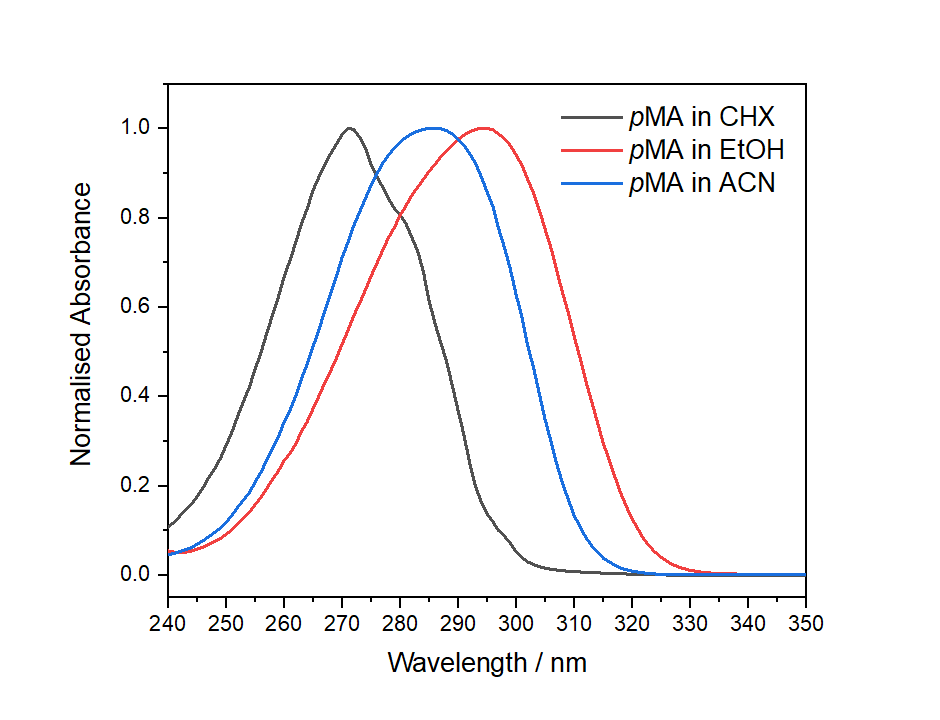
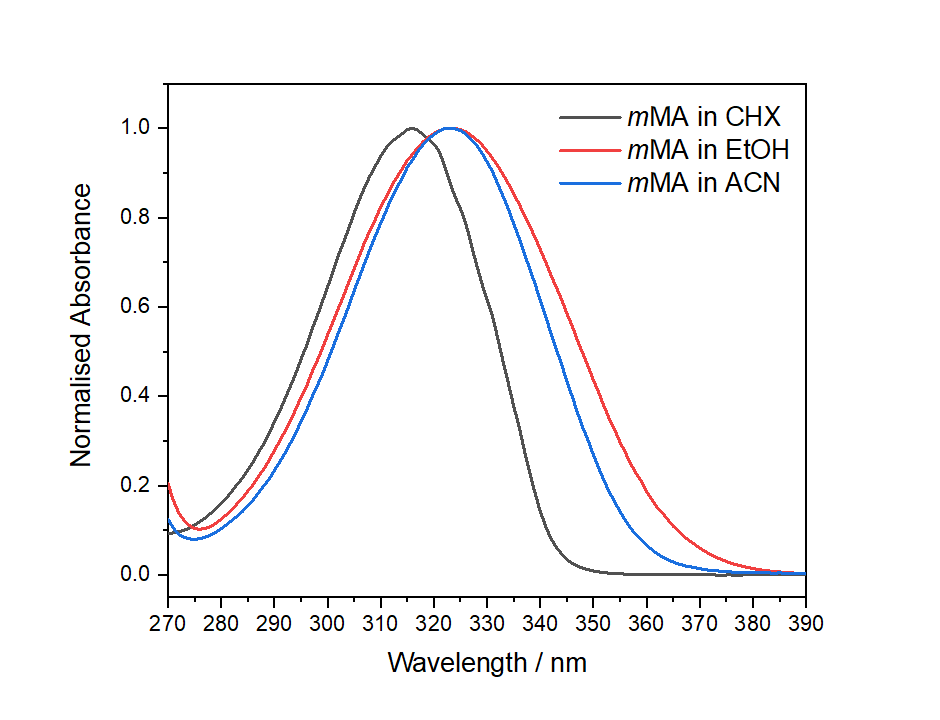

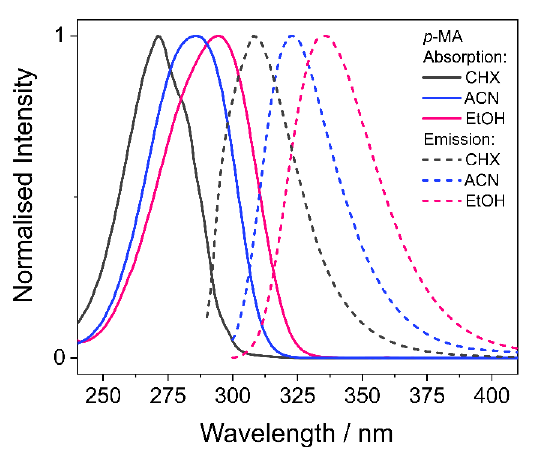

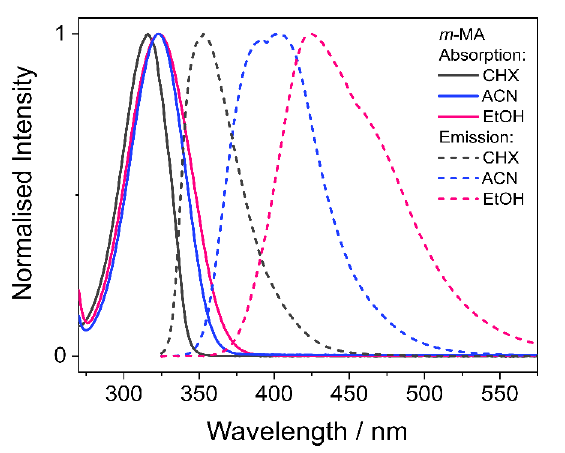

In [ ]:
# Plot un-warped solvated spectra

from esteem.tasks import spectra
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline
red,green,blue,purple,cyan,yellow = (np.array((256,0,0)),np.array((0,256,0)),np.array((0,0,256)),
                                     np.array((256,0,256)),np.array((0,256,256)),np.array((256,256,0)))
black = np.array((0,0,0))
spectra_args.broad = 0.05 # eV
#spectra_args.warp_params = [0.9387803024503101, 0.5843416131574886, 2.412143832684825, 3.2541782939632546] # eV
# nm

# The really important command for interactive plot updating
spectra_args.wavelength = [300,480,1]
spectra_args.warp_scheme = None
spectra_args.warp_params = [0]
spectra_args.inputformat = 'onetep'

from ipywidgets import interact, fixed

def plot_files(a,stem,suffix,t):
    global fig, ax #, spectra_args
    b = int(a/5)
    indices = [t[b][i].index for i in range(len(t[b])) if (t[b][i]).symbol=='O']
    #np.argmin(t[b].get_distance(1,np.array(indices)))
    #print(len(indices),np.sort(t[b].get_distances(10,indices))[0:4])

    spectra_args.files = [f'{stem}_solv{a:03}{suffix}']
    print(spectra_args.files)
    #ax.clear()
    spec,spec_plot,fig,ax,_ = spectra.main(spectra_args,fig=fig,ax=ax,rgb=red)
    fig.canvas.draw()
    
solvent = 'acet'
solute = 'pmab'
stem = f'{solute}_{solvent}_solvR8K8/{solute}_{solvent}'
suffix = '.out'
spectra_args.renorm = -1

from ase.visualize import view
from ase.io import Trajectory
from esteem.trajectories import merge_traj
from glob import glob

traj_pattern = f'{stem}_carved*.traj'
traj_files = glob(traj_pattern)
if (len(traj_files)==1 and traj_files[0]==traj_pattern):
    traj_files = []
print(traj_files)
traj = f"{stem}_merged.traj"
merge_traj(traj_files,traj)
t = Trajectory(traj)

fig = None; ax = None;
spectra_args.files = glob(f'{stem}_solv*{suffix}')
spec,all_spec_plot,fig,ax,_ = spectra.main(spectra_args,fig=fig,ax=ax,rgb=blue)

a=5
spectra_args.files = [f'{stem}_solv{a:03}{suffix}']
spec,spec_plot,fig,ax,_ = spectra.main(spectra_args,fig=fig,ax=ax,rgb=red)
a=190
spectra_args.files = [f'{stem}_solv{a:03}{suffix}']
spec,spec_plot,fig,ax,_ = spectra.main(spectra_args,fig=fig,ax=ax,rgb=red)

inty = interact(plot_files,a=(0,195,5),stem=fixed(stem),suffix=fixed(suffix),t=fixed(t));

#v=view(t,viewer='ngl')
#v.view.add_ball_and_stick()
#v
inty

In [ ]:
from ase.visualize import view; from ase.io import read
a=read("freq.hess.v006.xyz",index=slice(0,-1))

view(a,viewer='nglview')

In [ ]:

ax.plot([3.0, 2.2])


In [ ]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

plt.figure(2)
fig, ax = plt.subplots()

def f(m, b):
    #fig, ax = plt.subplots()
    x = np.linspace(-10, 10, num=1000)
    fig.clear()
    ax.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.draw()
    fig.canvas.draw()
    fig.canvas.flush_events()
    display(fig)

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
#output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot

In [ ]:
%matplotlib inline

# To prevent automatic figure display when execution of the cell ends
%config InlineBackend.close_figures=False 

import matplotlib.pyplot as plt
import numpy as np

from IPython.html import widgets
from IPython.display import display,clear_output

plt.ioff()
fig,ax=plt.subplots()

out=widgets.Output()
button=widgets.Button(description='Next')
vbox=widgets.VBox(children=(out,button))
display(vbox)

def click(b):
    ax.clear()
    ax.plot(np.random.randn(100),np.random.randn(100),'+')
    with out:
        clear_output(wait=True)
        display(fig)

#button.on_click(click)
#click(None)


from ipywidgets import interactive


In [ ]:
from ase.io import read
from os import chdir
chdir("/storage/nanosim/methyl_anthranilate")
pmab = read("xyz/pmab.xyz")
mmab = read("xyz/mmab.xyz")
omab = read("xyz/omab.xyz")

from ase.visualize import view

v=view([pmab,mmab],viewer='ngl')
v.view.add_ball_and_stick()
v

In [1]:
import numpy as np
from os import chdir
from ase.visualize import view
chdir("/storage/nanosim/methyl_anthranilate")
from ase.io import read,Trajectory
import ngl
from esteem.tasks.clusters import debug_cluster_trajectory,dist_test,delete_distant_molecules


traj=Trajectory("pma_acet_gs_A_NNABEF_mldyn_equil0000.traj")
print(len(traj))
nat_solu=20
nat_solv=6
start = 0

def dist_test2(mol):
    all_dist = mol.get_all_distances()
    if (all_dist>5).any() or np.logical_and((all_dist<0.75),(all_dist>0)).any():
        print(all_dist)
        return True
    else:
        return False
    
recent_frames = debug_cluster_trajectory(traj,nat_solu,nat_solv,start=start,end=len(traj),
                             before=34,after=20,badness_test_func=dist_test2,radius=3)

#frames = []
#for i,t in enumerate(recent_frames):
#    cut = delete_distant_molecules(t,4.0,len(t),nat_solv,int((len(t)-nat_solu)/nat_solv),nat_solu)
#    cut.rotate('y',90)
#    frames.append(cut)
    #print(len(frames[-1]))
#traj=[read("mma.xyz"),read("pma.xyz")]
v = ngl.view_ngl(recent_frames, w=900, h=900).view
v.add_ball_and_stick()
v

ModuleNotFoundError: No module named 'ngl'

In [ ]:
%matplotlib notebook

from os import chdir
import glob
chdir("/storage/nanosim/methyl_anthranilate/pma_etoh_solvR2.5/orca")
import numpy as np
red,green,blue = (np.array((256,0,0)),np.array((0,256,0)),np.array((0,0,256)))
purple,cyan,yellow = (np.array((256,0,192)),np.array((0,256,192)),np.array((256,192,0)))
lightred,lightgreen,lightblue = (np.array((256,128,128)),np.array((128,256,128)),np.array((0,128,256)))
black,grey = (np.array((0,0,0)),np.array((128,128,128)))
from esteem import drivers

from esteem.tasks.spectra import SpectraTask
spectra_task = SpectraTask()

spectra_task.broad = 0.1
spectra_task.inputformat = 'orca'
spectra_task.wavelength = [240,340,0.2]
spectra_task.line_colours = [red,lightred,blue,lightblue,black,grey,lightred,lightgreen,lightblue]
spectra_task.exc_suffix = 'orca'
#spectra_args.renorm = True
spectra_task.warp_scheme = None
spectra_task.renorm = True
c_fig = None; c_ax = None
solute='pma'; solvent='etoh'
pattern = f'{solute}_{solvent}_es2_A_orca*.out'
spectra_task.files = glob.glob(pattern)
cluster_spectrum,spec,c_fig,c_ax,_,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma in etoh 27C',rgb=blue)

chdir("/storage/nanosim/methyl_anthranilate/pma_etoh_solvS2.5/orca")
pattern = f'{solute}_{solvent}_es2_A_orca*.out'
spectra_task.files = glob.glob(pattern)
cluster_spectrum,spec,c_fig,c_ax,_,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma in etoh 77C',rgb=red)

chdir("/storage/nanosim/methyl_anthranilate/")

exp25 = np.loadtxt("pma_etoh_tdep_exp25C.dat")
exp75 = np.loadtxt("pma_etoh_tdep_exp75C.dat")

c_ax.plot(exp25[:,0],exp25[:,1]/np.max(exp25[:,1]),label='pma in etoh expt 25C',color='lightblue')
c_ax.plot(exp75[:,0],exp75[:,1]/np.max(exp75[:,1]),label='pma in etoh expt 75C',color='red')
c_ax.legend()

In [ ]:
%matplotlib notebook

from os import chdir
import glob
import numpy as np
red,green,blue = (np.array((256,0,0)),np.array((0,256,0)),np.array((0,0,256)))
purple,cyan,yellow = (np.array((256,0,192)),np.array((0,256,192)),np.array((256,192,0)))
lightred,lightgreen,lightblue = (np.array((256,128,128)),np.array((128,256,128)),np.array((128,128,256)))
black,grey = (np.array((0,0,0)),np.array((128,128,128)))
from esteem import drivers

from esteem.tasks.spectra import SpectraTask
spectra_task = SpectraTask()

spectra_task.broad = 0.05
spectra_task.inputformat = 'orca'
spectra_task.wavelength = [237,430,0.2]
spectra_task.line_colours = [red,lightred,blue,lightblue,black,grey,lightred,lightgreen,lightblue]
spectra_task.exc_suffix = 'orca'
#spectra_args.renorm = True
spectra_task.warp_scheme = None
spectra_task.renorm = True
c_fig = None; c_ax = None

chdir("/storage/nanosim/methyl_anthranilate/pma_etoh_solvR2.5/orca")
solute='pma'; solvent='etoh'
pattern = f'{solute}_{solvent}_es1_A_orca*.out'
spectra_task.files = glob.glob(pattern)
#cluster_spectrum,spec,c_fig,c_ax,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma in etoh AMBER',rgb=red)

chdir("/storage/nanosim/methyl_anthranilate/pma_cycl_solvR2.5/orca")
solute='pma'; solvent='cycl'
pattern = f'{solute}_{solvent}_es1_A_orca*.out'
spectra_task.files = glob.glob(pattern)
#cluster_spectrum,spec,c_fig,c_ax,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma in cycl AMBER',rgb=black)

chdir("/storage/nanosim/methyl_anthranilate/pma_etoh_gs_NNABEF_mlclus/orca")
solute='pma'; solvent='etoh'
pattern = f'{solute}_{solvent}_es1_A_orca*.out'
spectra_task.files = glob.glob(pattern)
cluster_spectrum,spec,c_fig,c_ax,_,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma in etoh PhysNet',rgb=red)

chdir("/storage/nanosim/methyl_anthranilate/pma_cycl_gs_NNABEF_mlclus/orca")
solute='pma'; solvent='cycl'
pattern = f'{solute}_{solvent}_es1_A_orca*.out'
spectra_task.files = glob.glob(pattern)
cluster_spectrum,spec,c_fig,c_ax,_,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma in cycl PhysNet',rgb=black)


chdir("/storage/nanosim/methyl_anthranilate/pma_etoh_es1_NNABEF_mlclus/orca")
solute='pma'; solvent='etoh'
pattern = f'{solute}_{solvent}_es1_A_orca*.out'
spectra_task.files = glob.glob(pattern)
cluster_spectrum,spec,c_fig,c_ax,_,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma in etoh PhysNet',rgb=lightred)

chdir("/storage/nanosim/methyl_anthranilate/pma_cycl_es1_NNABEF_mlclus/orca")
solute='pma'; solvent='cycl'
pattern = f'{solute}_{solvent}_es1_A_orca*.out'
spectra_task.files = glob.glob(pattern)
cluster_spectrum,spec,c_fig,c_ax,_,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma in cycl PhysNet',rgb=grey)


chdir("/storage/nanosim/methyl_anthranilate/")
a=0.98
etoh_gs_expt = np.loadtxt("pma_etoh_gs_expt.dat")
c_ax.plot(etoh_gs_expt[:,0],a*etoh_gs_expt[:,1]/np.max(etoh_gs_expt[:,1]),'r:',label='pma in etoh expt. abs')
cycl_gs_expt = np.loadtxt("pma_cycl_gs_expt.dat")
c_ax.plot(cycl_gs_expt[:,0],a*cycl_gs_expt[:,1]/np.max(cycl_gs_expt[:,1]),'k:',label='pma in cycl expt. emis')
etoh_es1_expt = np.loadtxt("pma_etoh_es1_expt.dat")
c_ax.plot(etoh_es1_expt[:,0],a*etoh_es1_expt[:,1]/np.max(etoh_es1_expt[:,1]),'r:',label='pma in etoh expt. abs')
cycl_es1_expt = np.loadtxt("pma_cycl_es1_expt.dat")
c_ax.plot(cycl_es1_expt[:,0],a*cycl_es1_expt[:,1]/np.max(cycl_es1_expt[:,1]),'k:',label='pma in cycl expt. emis')
c_ax.legend()

In [ ]:
import matplotlib.pyplot as plt
c_fig = None; c_ax = None
spectra_task.broad = 0.1

spectra_task.vib_files = None
chdir("/storage/nanosim/methyl_anthranilate/pma_etoh_solvR2.5/orca")
solute='pma'; solvent='etoh'
pattern = f'{solute}_{solvent}_es2_A_orca*.out'
spectra_task.files = glob.glob(pattern)
cluster_spectrum,spec,c_fig,c_ax,_,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma in etoh Amber gs traj',rgb=grey)

chdir("/storage/nanosim/methyl_anthranilate/pma_etoh_es1_NNABEF_clus/orca")
solute='pma'; solvent='etoh'
pattern = f'{solute}_{solvent}_es1_A_orca*.out'
spectra_task.files = glob.glob(pattern)
cluster_spectrum,spec,c_fig,c_ax,_,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma in etoh ML es1 traj',rgb=red)

chdir("/storage/nanosim/methyl_anthranilate/pma_etoh_gs_NNABEF_mlclus/orca")
solute='pma'; solvent='etoh'
pattern = f'{solute}_{solvent}_es1_A_orca*.out'
spectra_task.files = glob.glob(pattern)
cluster_spectrum,spec,c_fig,c_ax,_,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma in etoh gs ML traj',rgb=purple)

chdir("/storage/nanosim/methyl_anthranilate/")
exp = np.loadtxt("pma_etoh_tdep_exp25C.dat")
c_ax.plot(exp[:,0],exp[:,1]/np.max(exp[:,1]),label='pma in etoh experimental abs')
c_ax.legend()


In [4]:
from ase.io import Trajectory
from ase.visualize import view
from os import chdir
chdir("/storage/nanosim/methyl_anthranilate")
t=Trajectory("pma_etoh_gs_A_NNABCDEGHJMNPSTV_mldyn_md0000_carved.traj")
view(t,viewer='nglview')

In [ ]:
from esteem.tasks import spectra
import numpy as np
from os import chdir
import glob
import matplotlib.pyplot as plt
%matplotlib notebook
red,green,blue = (np.array((256,0,0)),np.array((0,256,0)),np.array((0,0,256)))
purple,cyan,yellow = (np.array((256,0,192)),np.array((0,256,192)),np.array((256,192,0)))
lightred,lightgreen,lightblue = (np.array((256,128,128)),np.array((128,256,128)),np.array((128,128,256)))
black,grey = (np.array((0,0,0)),np.array((128,128,128)))

from esteem.tasks.spectra import SpectraTask
spectra_task = SpectraTask()
spectra_task.broad = 0.05
spectra_task.inputformat = 'orca'
spectra_task.wavelength = [237,430,0.2]
spectra_task.line_colours = [red,lightred,blue,lightblue,black,grey,lightred,lightgreen,lightblue]
spectra_task.exc_suffix = 'orca'
#spectra_args.renorm = True
spectra_task.warp_scheme = None
spectra_task.renorm = True

c_fig = None; c_ax = None
chdir("/storage/nanosim/methyl_anthranilate/pma_etoh_gs_NNABEF_mlclus/orca_R3.0")
solute='pma'; solvent='etoh'
pattern = f'{solute}_{solvent}_es1_A_orca*.out'
spectra_task.files = glob.glob(pattern)
spectra_task.vib_files = None #f'../../{solute}_{solvent}.xml.spectrum_dushinsky'
cluster_spectrum,spec,c_fig,c_ax,_,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma explicit etoh no vib',rgb=lightred)
spectra_task.vib_files = f'../../{solute}_{solvent}.xml.spectrum_dushinsky'
cluster_spectrum,spec,c_fig,c_ax,_,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma explicit etoh with vib',rgb=red)

chdir("/storage/nanosim/methyl_anthranilate/")
spec = np.loadtxt("spectrum.dat")
spec[:,0] = spectra.wavelength_eV_conv/spec[:,0]
#spec[:,0] = spec[:,0] #-4.275
spec[:,1] = spec[:,1]/np.max(spec[:,1])
#x_.xlabel('Energy (eV)')
#plt.ylabel('pma implicit etoh full-FC')
c_ax.plot(spec[:,0],spec[:,1], label='pma implicit etoh full-FC')

etoh_gs_expt = np.loadtxt("pma_etoh_gs_expt.dat")
c_ax.plot(etoh_gs_expt[:,0],etoh_gs_expt[:,1]/np.max(etoh_gs_expt[:,1]),'k:',label='pma in etoh expt. abs')
c_ax.legend()
plt.show()

In [ ]:
from esteem.tasks import spectra
import numpy as np
from os import chdir
import glob
import matplotlib.pyplot as plt
%matplotlib notebook
red,green,blue = (np.array((256,0,0)),np.array((0,256,0)),np.array((0,0,256)))
purple,cyan,yellow = (np.array((256,0,192)),np.array((0,256,192)),np.array((256,192,0)))
lightred,lightgreen,lightblue = (np.array((256,128,128)),np.array((128,256,128)),np.array((128,128,256)))
black,grey = (np.array((0,0,0)),np.array((128,128,128)))

from esteem.tasks.spectra import SpectraTask
spectra_task = SpectraTask()
spectra_task.broad = 0.1
spectra_task.inputformat = 'orca'
spectra_task.wavelength = [237,350,0.2]
spectra_task.line_colours = [red,lightred,blue,lightblue,black,grey,lightred,lightgreen,lightblue]
spectra_task.exc_suffix = 'orca'
#spectra_args.renorm = True
spectra_task.warp_scheme = None
spectra_task.renorm = True

c_fig = None; c_ax = None
chdir("/storage/nanosim/methyl_anthranilate/pma_etoh_gs_NNABEF_mlclus/orca_R3.0")
solute='pma'; solvent='etoh'
pattern = f'{solute}_{solvent}_es1_A_orca*.out'
spectra_task.files = glob.glob(pattern)
spectra_task.vib_files = None
cluster_spectrum,spec,c_fig,c_ax,_,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma in etoh PhysNet no vib',rgb=green)
spectra_task.vib_files = f'../../{solute}_{solvent}.xml.spectrum_dushinsky'
cluster_spectrum,spec,c_fig,c_ax,_,_ = spectra_task.main(c_fig,c_ax,plotlabel='pma in etoh PhysNet full FC',rgb=red)

chdir("/storage/nanosim/methyl_anthranilate/")
spec = np.loadtxt("spectrum.dat")
spec[:,0] = spectra.wavelength_eV_conv/spec[:,0]
spec[:,1] = spec[:,1]/np.max(spec[:,1])
#x_.xlabel('Energy (eV)')
#plt.ylabel('pma implicit etoh full-FC')
c_ax.plot(spec[:,0],spec[:,1], label='pma implicit etoh full-FC')

etoh_gs_expt = np.loadtxt("pma_etoh_gs_expt.dat")
c_ax.plot(etoh_gs_expt[:,0],etoh_gs_expt[:,1]/np.max(etoh_gs_expt[:,1]),'k:',label='pma in etoh expt. abs')
c_ax.legend()
plt.show()

In [ ]:
%matplotlib notebook

from esteem.tasks.ml_trajectories import load_trajectory_dipole, calculate_ir_spectrum
import matplotlib.pyplot as plt
import numpy as np

solu = "pma"
solv = "etoh"
seed_state_str = f"{solu}_{solv}_gs"
traj_suffix = "NNABEF_mldyn_snaps"
nsnaps = 1
ntraj = 1
mdsteps = 20000

# 40000fs trajectories, 0.5fs timestep corresponds to 0.83391 cm^-1 spacing, up to 66712.81904 cm^-1
from ase import units
freq_scale_fac = (1e15/units._c/100)*0.96
dt = 0.5
sigma=20
plotmax = 1200

import jcamp
jcamp_dict = jcamp.JCAMP_reader(f"{solv}_expt_ir.jdx")
ystart = 7879
ylen = len(jcamp_dict['y'])-4
plt.plot(jcamp_dict['x'][ystart:ylen],jcamp_dict['y'][ystart:ylen],label='etoh NIST webbook')

jcamp_dict2 = jcamp.JCAMP_reader(f"omab_expt_ir.jdx")
ystart = 7879
ylen = len(jcamp_dict2['y'])-4
plt.plot(jcamp_dict2['x'],jcamp_dict2['y'],label='oMA NIST webbook')

mu_t = load_trajectory_dipole(seed_state_str,traj_suffix,ntraj,nsnaps,mdsteps)
mu_dot_tilde_av_mag_conv, omega = calculate_ir_spectrum(mu_t,dt,freq_scale_fac,sigma)

plt.plot(omega[:plotmax],mu_dot_tilde_av_mag_conv[:plotmax]/np.max(mu_dot_tilde_av_mag_conv[:plotmax]),
         label='PhysNet NNABEF MD trajectory FTIR')
plt.legend()
plt.show()

In [ ]:
for i,x in enumerate(jcamp_dict2['x']):
    print(i,x,jcamp_dict2['y'][i])

In [ ]:

import matplotlib.pyplot as plt
%matplotlib notebook

r=np.loadtxt('results')

p=sorted(range(len(r[:,2])), key=lambda k: r[k,0])
pbig = p[int(len(p)*0.8):len(p)]
#rbig = np.zeros((len(rbig),2))
rbig = r[pbig]
plt.scatter(r[:,2],r[:,1])
plt.scatter(rbig[:,2],rbig[:,1])
print(np.mean(r[:,2]),np.mean(rbig[:,1]))

plt.ylabel('Mean absolute error of 4 calculators compared to DFT (eV)')
plt.xlabel('Std Dev of predictions of 4 calculators (eV)')
plt.show()

In [ ]:

import matplotlib.pyplot as plt
%matplotlib notebook

r=np.loadtxt('results')

p=sorted(range(len(r[:,0])), key=lambda k: r[k,0])
pbig = p[int(len(p)*0.8):len(p)]
#rbig = np.zeros((len(rbig),2))
rbig = r[pbig]
plt.scatter(r[:,2],r[:,1])
plt.scatter(rbig[:,2],rbig[:,1])
print(np.mean(r[:,1]),np.mean(rbig[:,1]))

plt.ylabel('Mean absolute error of 4 calculators compared to DFT (eV)')
plt.xlabel('Std Dev of predictions of 4 calculators (eV)')
plt.show()

In [ ]:
from ase.io import read, Trajectory
from ase.visualize import view
!pwd
v=view(Trajectory("/storage/nanosim/methyl_anthranilate/acet_acet_md_pos.traj"),viewer='nglview')
v.view.add_ball_and_stick()
v

In [ ]:
from ase.io import Trajectory; from ase.visualize import view
t=Trajectory("/storage/nanosim/methyl_anthranilate/pma_etoh_gs_NNABEF_mldyn/pma_etoh_gs_F_NNABEF_mldyn_snaps0000.traj")
import numpy as np

energies = np.zeros((len(t),4))
for i,a in enumerate(t):
    if i%1000==0:
        print(i,len(t))
    energies[i,0] = a.get_kinetic_energy()
    energies[i,1] = a.get_potential_energy()
    energies[i,2] = a.get_total_energy()
    energies[i,3] = a.get_temperature()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
fig, axs = plt.subplots(2, 2)
#gs = fig.add_gridspec(3, hspace=0)
#axs = gs.subplots(2,2,sharex=True, sharey=True)

#gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
#axs = gs.subplots(sharex='col', sharey='row')

axs[0, 0].plot(energies[:,1])
axs[0, 0].set_title('Potential Energy')
axs[0, 1].plot(energies[:,0], 'tab:orange')
axs[0, 1].set_title('Kinetic Energy')
axs[1, 0].plot(energies[:,2], 'tab:green')
axs[1, 0].set_title('Total Energy')
axs[1, 1].plot(energies[:,3], 'tab:red')
axs[1, 1].set_title('Temperature')

for ax in axs.flat:
    ax.set(xlabel='Time / 0.5fs', ylabel='eV')
axs[1, 1].set(ylabel='K')
fig.tight_layout()
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()